# Big data in xarray 

In [Intake_tutorial_p1](Intake_tutorial_p1.ipynb), we explored the data available in the ACCESS-NRI Intake catalog and open some data for analysis. We did this using xarray datasets, and you may notice when you inspect these they don't show any data, only [dask](https://docs.xarray.dev/en/stable/user-guide/dask.html) objects. 

In [2]:
import intake

catalog = intake.cat.access_nri

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import gc

In [4]:
from distributed import Client

client = Client(threads_per_worker=1)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41419,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:38847,Total threads: 1
Dashboard: /proxy/36165/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:38241,


For example, if we look at sea surface temperature from ACCESS-OM2. 

In [6]:
%%time
sst_ds = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable='sst', frequency='1mon').to_dask()

CPU times: user 4 s, sys: 1.14 s, total: 5.14 s
Wall time: 19.5 s


In [7]:
sst_ds.sst

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<concatenate, shape=(732, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

Even though there is 4GB of data there, it opened very fast - about a second. This is becuase the data is loaded 'lazily'. The `to_dask` function uses xarray under the covers, and xarray here has loaded only the coordinates (x,y,time) into memory, and just enough information that it could load `sst` if needed.

It is available to do operations on, and is basically silent to the user its been loaded lazily. e.g. we can analyze and plot:

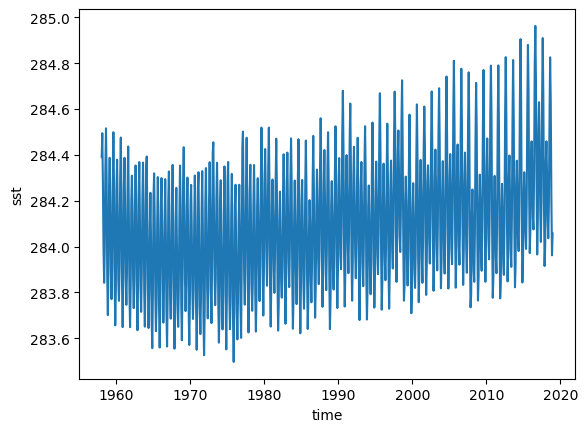

CPU times: user 37.6 s, sys: 1.34 s, total: 39 s
Wall time: 39.8 s


In [8]:
%%time
sst_ds.sst.mean(['xt_ocean','yt_ocean']).plot()
#Note the correct way to do a global mean of sst would be to weight each cell by it's area !

Our dataset is small enough it could fit in memory, so we could just load it when we open it. This takes longer to open but might be faster then to analyse. So we don't run into any speedups from caching, lets repeat using the _sss_ variable which is the same size as _sst_ and load it into memory initially.

In [8]:
%%time
sss_ds = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable='sss', frequency='1mon').to_dask().load()

CPU times: user 25.7 s, sys: 4.82 s, total: 30.5 s
Wall time: 32.4 s


In this case when we inspect the dataset, clicking the three discs symbol next to SSS shows us the data because we have loaded it already

In [9]:
sss_ds.sss

<xarray.DataArray 'sss' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_salinity

CPU times: user 3.13 s, sys: 1.18 s, total: 4.31 s
Wall time: 3.64 s


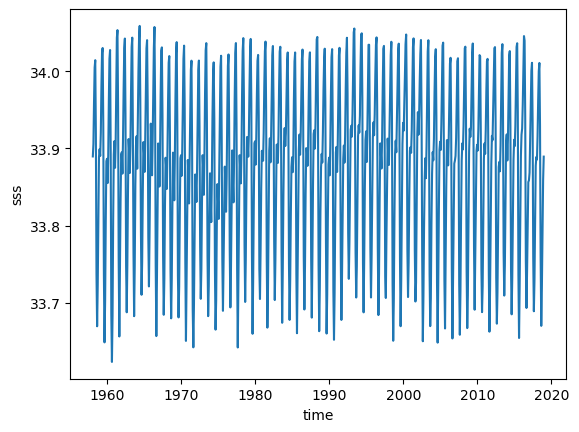

In [10]:
%%time
sss_ds.sss.mean(['xt_ocean','yt_ocean']).plot()
#Note the correct way to do a global mean would be to weight each cell by it's area !

The overall run time to plot loading the data when opening is slower than loading lazily! However if you need to do multiple operations, and your data fits in memory, it may still be quicker overall to load the data into memory. Lazy loading means you might end up loading it from disc multiple times unesecarily.

Back to our _sst_ data

If we inspect the mean operation we did before plotting:

In [13]:
%%time
sst_rechunk = sst_ds.sst.chunk({'yt_ocean':-1,'xt_ocean':-1, 'time':'auto'})

CPU times: user 87.7 ms, sys: 800 μs, total: 88.5 ms
Wall time: 86.5 ms


In [14]:
sst_rechunk

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(21, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

CPU times: user 19.2 s, sys: 400 ms, total: 19.6 s
Wall time: 21.1 s


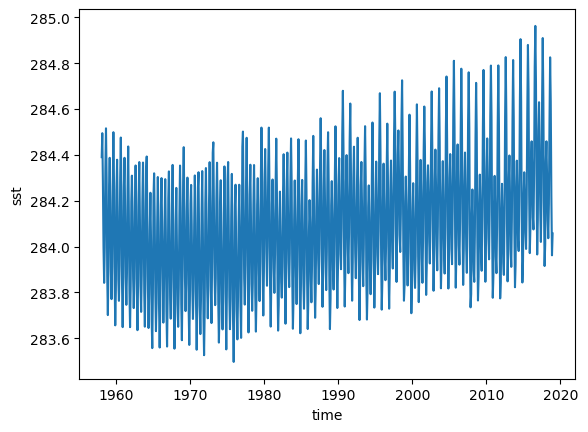

In [15]:
%%time
sst_rechunk.mean(['xt_ocean','yt_ocean']).plot()
#Note the correct way to do a global mean of sst would be to weight each cell by it's area !

We've saved about 15 seconds ... showing us its not enough at this amount of data to be worth the effort really. But if we scale up, we can see the benefits!

If we chunk as badly as we can:

In [18]:
%%time
sst_badchunk = sst_ds.sst.chunk({'yt_ocean':1,'xt_ocean':1, 'time':-1})

CPU times: user 27.5 s, sys: 814 ms, total: 28.3 s
Wall time: 28.3 s


In [19]:
sst_badchunk

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(732, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [ ]:
%%time
sst_badchunk.mean(['xt_ocean','yt_ocean']).plot()
#Note the correct way to do a global mean of sst would be to weight each cell by it's area !

Don't try this:

```python
sst_badchunk.mean(['xt_ocean','yt_ocean']).plot()
```
The kernal would crash

CPU times: user 28.5 s, sys: 619 ms, total: 29.2 s
Wall time: 30.8 s


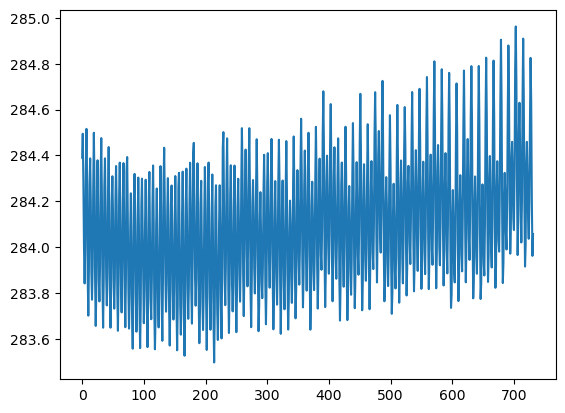

In [23]:
%%time
plt.plot(np.mean(sst_ds.sst, axis=[1,2]))

We can do the same calculate using a for loop:

CPU times: user 29.6 s, sys: 4.85 s, total: 34.4 s
Wall time: 35.9 s


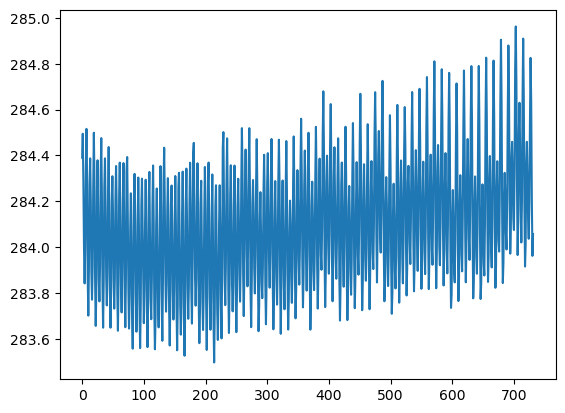

In [24]:
%%time

sst = sst_ds.sst.values

mean = np.zeros(len(sst))

for i in range(0,len(sst)):
    mean[i] = np.nanmean(sst[i,:,:])

plt.plot(mean)

CPU times: user 37.3 s, sys: 927 ms, total: 38.3 s
Wall time: 39.7 s


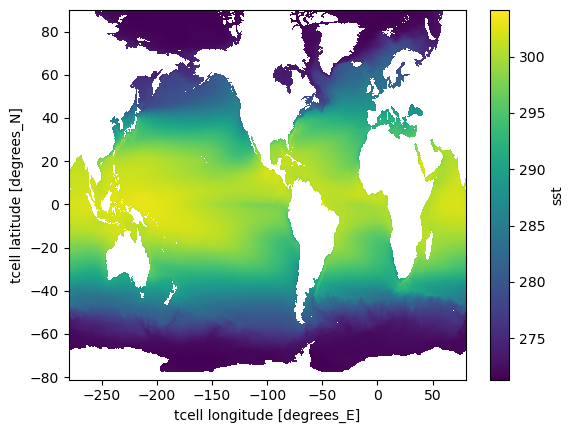

In [40]:
%%time
sst_ds.sst.mean(['time']).plot()
#n.b. to do this correctly we should include the real latitude and longitude, note the plots are skewed north of 65°N

Optimising the chunks here to calculate the mean over all time is not the right answer, because its splits the chunks ( and therefore adds tasks) :

In [26]:
sst_ds.sst.chunk({'time':-1, 'xt_ocean':'auto','yt_ocean':'auto'})

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(732, 203, 225), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

CPU times: user 52.3 s, sys: 919 ms, total: 53.2 s
Wall time: 55.5 s


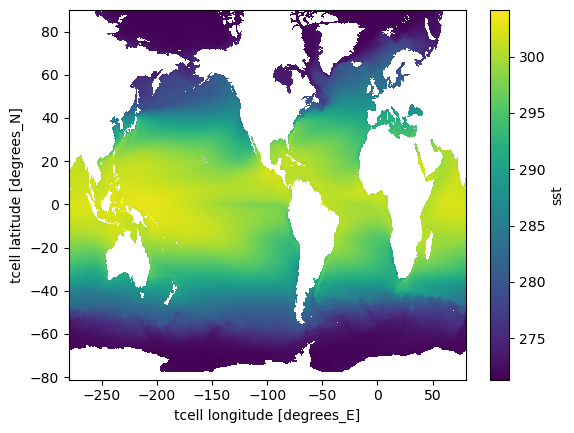

In [27]:
%%time
sst_ds.sst.chunk({'time':-1, 'xt_ocean':'auto','yt_ocean':'auto'}).mean(['time']).plot()

In [28]:
gc.collect()

14702

Just combining chunks is faster

In [30]:
sst_ds.sst.chunk({'time':'auto'})

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(647, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

CPU times: user 18.8 s, sys: 392 ms, total: 19.2 s
Wall time: 20.7 s


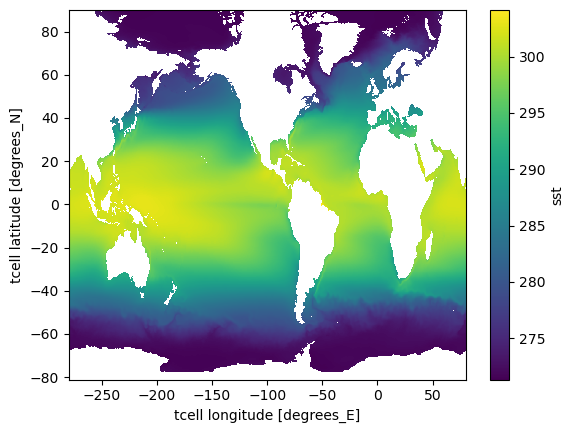

In [29]:
%%time
sst_ds.sst.chunk({'time':'auto'}).mean(['time']).plot()

In [31]:
gc.collect()

93840

There's very marginal gains in making the chunks a little bigger:

In [32]:
sst_ds.sst.chunk({'time':-1})

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(732, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

CPU times: user 18.1 s, sys: 402 ms, total: 18.5 s
Wall time: 19.9 s


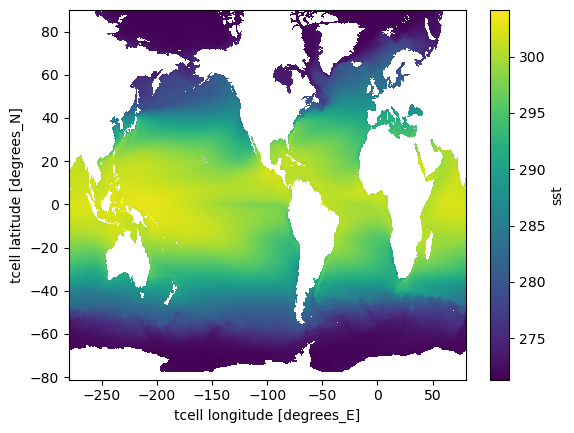

In [33]:
%%time
sst_ds.sst.chunk({'time':-1}).mean(['time']).plot()

In [34]:
gc.collect()

94035

However doubling the chunksize (whilst keeping the size a whole number of the original chunksizes) makes no appreciable difference

In [48]:
sst_ds.sst.chunk({'time':-1, 'xt_ocean':480,'yt_ocean':216})

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(732, 216, 480), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

CPU times: user 18.4 s, sys: 458 ms, total: 18.9 s
Wall time: 21.5 s


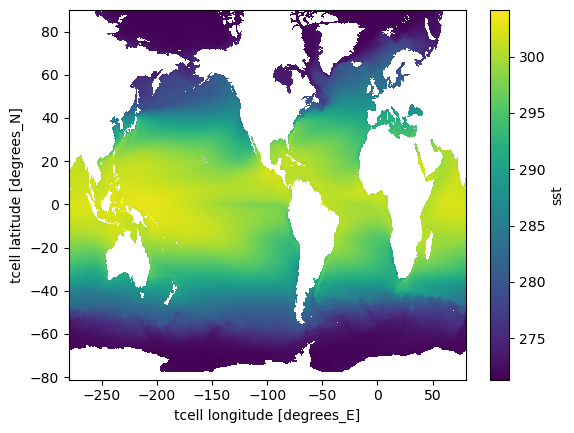

In [49]:
%%time
sst_ds.sst.chunk({'time':-1, 'xt_ocean':480,'yt_ocean':216}).mean('time').plot()

In [50]:
gc.collect()

186141

Making the chunks any bigger would lead to idle tasks, and therefore not be using all the compute resources available efficiently

In [48]:
sst_ds.sst.chunk({'time':-1, 'xt_ocean':480,'yt_ocean':216})

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(732, 216, 480), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

## Scaling up

In [ ]:
catalog['01deg_jra55v140_iaf_cycle4'].search(variable='temp_surface_ave').df

In [ ]:
catalog['01deg_jra55v140_iaf_cycle4'].search(variable='temp').to_dask()

In [ ]:
client.close()

# ack 